# Path embeddings with FastPATH - Examples

# The dataset
In this notebook we will show you several examples of constructing path embeddings for patient journeys in a synthetic dataset with Patients, Encounters, Conditions, Observations and more.
You need to replace the neo4j url and credentials to a database that contains the dataset.



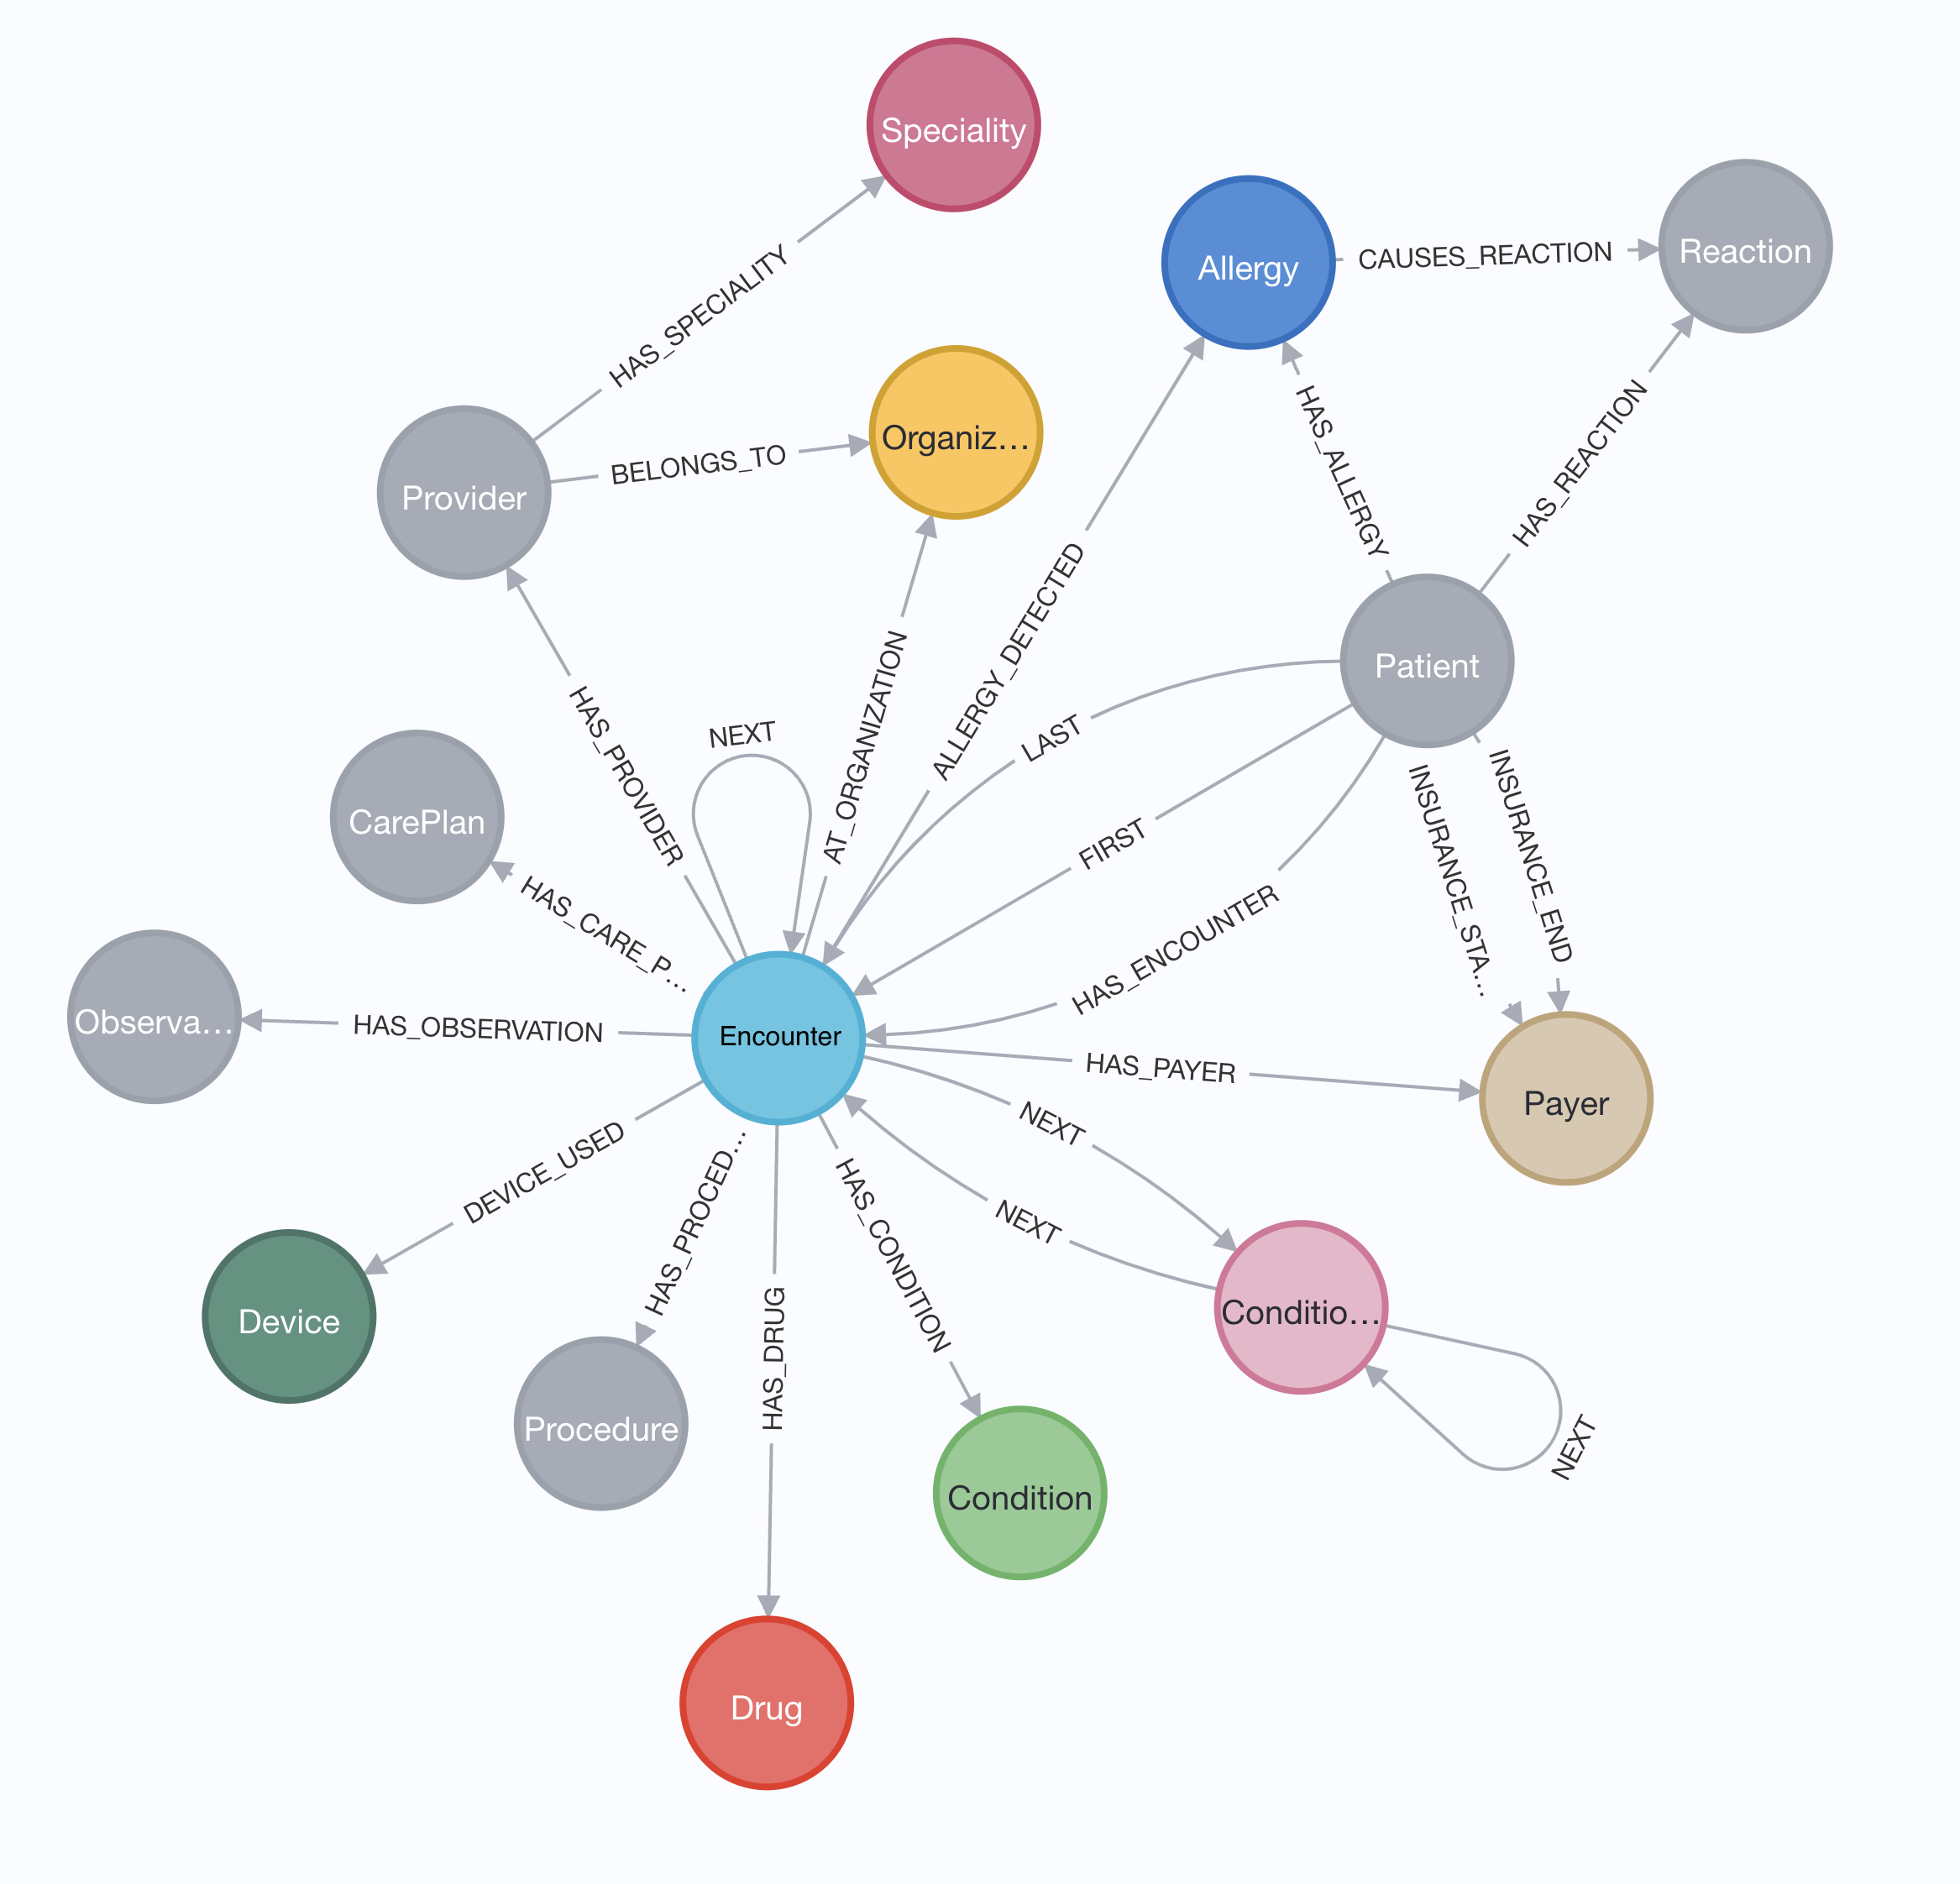

In [225]:
from graphdatascience import GraphDataScience
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = [15, 10]

In [226]:
gds = GraphDataScience(
    "neo4j+s://eddb7e19.databases.neo4j.io",
    auth=("neo4j", "Oz4oBK--Sx4byHjgHgJuMf5VqQncGHG9mbgpy44rQTU"),
    database="neo4j",
)
gds.set_compute_cluster_ip("localhost")

### Run the preprocessing cells below on your dataset, but only once!


Write a has_diabetes property (0 or 1) to each Patient

In [4]:
# gds.run_cypher("MATCH (p:Patient) SET p.has_diabetes=0")
# gds.run_cypher("MATCH (p:Patient)-[:HAS_ENCOUNTER]->(n:Encounter)-[:HAS_CONDITION]-(c:Condition) WHERE c.description='Diabetes' SET p.has_diabetes=1")


Write the number of days since 1 January 1970 (can be negative) to each Encounter


In [ ]:
# gds.run_cypher("MATCH (n:Encounter) WITH toInteger(datetime(n.start).epochseconds/(24 * 3600)) as days, n SET n.days=days")

* Write two output time properties to each Patient based on the last Encounter before a diabetes diagnosis or the last Encounter otherwise
    * "output_time" is 1 + the timestamp of last encounter (before diabetes)
    * "output_time_stepwise" the number of encounters up to and including the last encounter (before diabetes)

In [ ]:
# gds.run_cypher("MATCH (p:Patient)-[:LAST]->(n:Encounter) SET p.output_time=n.days+1")
# gds.run_cypher("MATCH (p:Patient)-[:HAS_ENCOUNTER]->(e1:Encounter)-[:NEXT]->(e2:Encounter)-[:HAS_CONDITION]->(c:Condition) WHERE c.description='Diabetes' SET p.output_time=e1.days + 1")
# gds.run_cypher("MATCH (p:Patient)-[:HAS_ENCOUNTER]->(e:Encounter) WHERE e.days <= p.output_time - 1 WITH p, count(*) as cc SET p.output_time_stepwise=cc")


Write the class of each Encounter as an integer

In [609]:
#MATCH (e:Encounter) with distinct e.class AS class
#WITH collect(class) as clss
#WITH apoc.map.fromLists(clss, range(0, size(clss) - 1)) as classMap
#MATCH (e:Encounter) SET e.intClass = classMap[e.class]

In [612]:
try:
    G = gds.graph.get("medical")
    G.drop()
except:
    pass

G, _ = gds.graph.project(
    "medical",
    {
        "Patient": {"properties": ["output_time", "has_diabetes"]},
        "Encounter": {"properties": ["days", "intClass"]},
        "Observation": {"properties": []},
        "Payer": {"properties": []},
        "Provider": {"properties": []},
        "Organization": {"properties": []},
        "Speciality": {"properties": []},
        "Allergy": {"properties": []},
        "Reaction": {"properties": []},
        "Condition": {"properties": []},
        "Drug": {"properties": []},
        "Procedure": {"properties": []},
        "CarePlan": {"properties": []},
        "Device": {"properties": []},
        "ConditionDescription": {"properties": []},
    },
    [
        "HAS_OBSERVATION",
        "HAS_ENCOUNTER",
        "HAS_PROVIDER",
        "AT_ORGANIZATION",
        "HAS_PAYER",
        "HAS_SPECIALITY",
        "BELONGS_TO",
        "INSURANCE_START",
        "INSURANCE_END",
        "HAS_ALLERGY",
        "ALLERGY_DETECTED",
        "HAS_REACTION",
        "CAUSES_REACTION",
        "HAS_CONDITION",
        "HAS_DRUG",
        "HAS_PROCEDURE",
        "HAS_CARE_PLAN",
        "DEVICE_USED",
    ],
)

In [613]:
gds.fastRP.mutate(
    G,
    embeddingDimension=256,
    mutateProperty="emb",
    iterationWeights=[1, 1],
    randomSeed=42,
)

nodePropertiesWritten                                                82395
mutateMillis                                                             0
nodeCount                                                            82395
preProcessingMillis                                                      0
computeMillis                                                          230
configuration            {'randomSeed': 42, 'mutateProperty': 'emb', 'j...
Name: 0, dtype: object

## Preparing code for machine learning and visualization of embeddings
Below we will define come functions that we can run after each of a number of examples.

In [595]:
@ignore_warnings(category=ConvergenceWarning)
def explore(embeddings, timestamp):
     
    ## Compute distances between embeddings of healty - healthy, sick - sick and healthy - sick.
    
    diabetes_by_nodeId = gds.graph.streamNodeProperties(G, ['has_diabetes'], ['Patient']).set_index('nodeId')[['propertyValue']]
    emb_and_diabetes = embeddings[['nodeId', timestamp]].set_index('nodeId').merge(diabetes_by_nodeId, left_index=True, right_index=True)
    healthy_embs = np.array(emb_and_diabetes[emb_and_diabetes.propertyValue == 0][timestamp].tolist())
    diabetes_embs = np.array(emb_and_diabetes[emb_and_diabetes.propertyValue == 1][timestamp].tolist())
    
    diabetes_distances = []
    for i in range(diabetes_embs.shape[0]):
        for j in range(i + 1, diabetes_embs.shape[0]):
            x1 = diabetes_embs[i, :]
            x2 = diabetes_embs[j, :]
            diabetes_distances.append(np.linalg.norm(x1 - x2))
    print(f"Diabetes distances: {np.mean(diabetes_distances)}")
    healthy_distances = []
    for i in range(healthy_embs.shape[0]):
        for j in range(i + 1, healthy_embs.shape[0]):
            x1 = healthy_embs[i, :]
            x2 = healthy_embs[j, :]
            healthy_distances.append(np.linalg.norm(x1 - x2))
    
    print(f"Healthy distances: {np.mean(healthy_distances)}")
    
    mixed_distances = []
    for i in range(diabetes_embs.shape[0]):
        for j in range(healthy_embs.shape[0]):
            x1 = diabetes_embs[i, :]
            x2 = healthy_embs[j, :]
            mixed_distances.append(np.linalg.norm(x1 - x2))
    
    print(f"Mixed distances: {np.mean(mixed_distances)}")
    
    ## TSNE time
    
    X = np.array(emb_and_diabetes[timestamp].tolist())
    y = emb_and_diabetes.propertyValue.to_numpy()
    tsne = TSNE(2)
    tsne_result = tsne.fit_transform(X)
    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
    fig, ax = plt.subplots(1)
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=10)
    lim = (tsne_result.min()-5, tsne_result.max()+5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    
    ## Train evaluate diabetes classifier :)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
    
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
        
    train_f1_score = f1_score(y_train, y_train_pred, average="macro")
    test_f1_score = f1_score(y_test, y_test_pred, average="macro")

        
    print(f"Train f1: {train_f1_score}")
    print(f"Test f1: {test_f1_score}")


# Examples with input event vectors
In the following few examples we will use the fastrp embeddings of Encounters as input source.


## Example with single output time
To use a single fixed output time, you can either
* use num_output_times=1 (and optionally use subgraph filtering to run only up to a certain time) or
* use cypher to write a output time property to the Patient nodes holding a fixed timestamp (then provide it as output_time_property)

Here we will use the first option.

In [586]:
embeddings = gds.fastpath.stream(
    G,
    base_node_label="Patient",
    event_node_label="Encounter",
    event_features="emb",
    time_node_property="days",
    dimension=256,
    num_elapsed_times=100,
    num_output_times=1,
    max_elapsed_time=365 * 10,
    smoothing_rate=0.004,
    smoothing_window=3,
    decay_factor=1e-5,
    random_seed=42,
)
print(embeddings.columns)


INFO:root:Job with ID '8e6e8d70-c5b5-43ad-9c7d-b6b60743b931' started


RuntimeError: FastPath job failed with errors:
Internal server error

In [ ]:
explore(embeddings, '19430')

## Example with varying output time

In [155]:
embeddings = gds.fastpath.stream(
    G,
    base_node_label="Patient",
    event_node_label="Encounter",
    event_features="emb",
    time_node_property="days",
    dimension=256,
    num_elapsed_times=100,
    output_time_property="output_time",
    max_elapsed_time=365 * 10,
    smoothing_rate=0.004,
    smoothing_window=3,
    decay_factor=1e-4,
    random_seed=42,
)



INFO:root:Job with ID 'faeb562d-1a0f-4352-b84e-a8156036b0b9' started
INFO:root:FastPath job completed!


Diabetes distances: 113.59443436029372
Healthy distances: 389.6480358571425
Mixed distances: 276.19548817532853
Train f1: 1.0
Test f1: 0.9086195194787566


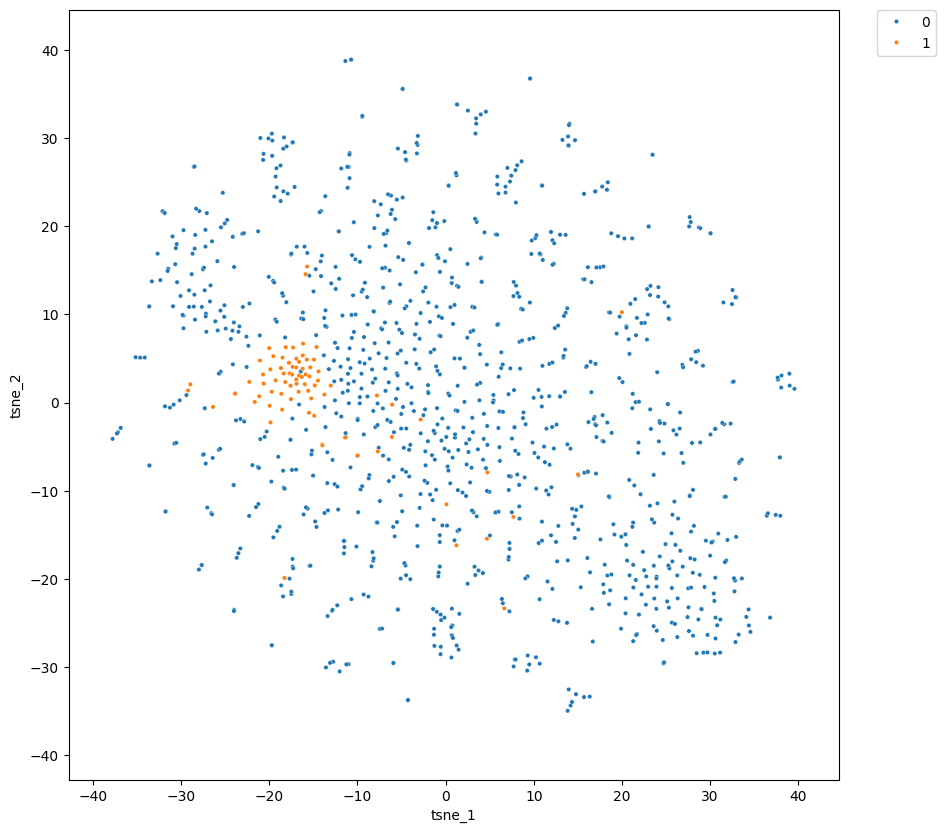

In [499]:
explore(embeddings, 'embeddings')

# Example with categorical event property and input event vectors
As the type (class) of encounter may be important to characterize patient journeys and to classify diabetes, we 'intClass' as a categorical event property.

In [185]:
embeddings = gds.fastpath.stream(
    G,
    base_node_label="Patient",
    event_node_label="Encounter",
    event_features="emb",
    time_node_property="days",
    categorical_event_properties=['intClass'],
    dimension=256,
    num_elapsed_times=100,
    output_time_property="output_time",
    max_elapsed_time=365 * 10,
    smoothing_rate=0.004,
    smoothing_window=3,
    decay_factor=1e-4,
    random_seed=42,
)



INFO:root:Job with ID '03ae8f4a-62ae-46ba-8d7b-18f81ea981b0' started
INFO:root:FastPath job completed!


Diabetes distances: 143.97025262974748
Healthy distances: 514.4944006679098
Mixed distances: 360.3695483368099
Train f1: 1.0
Test f1: 0.8346595932802829


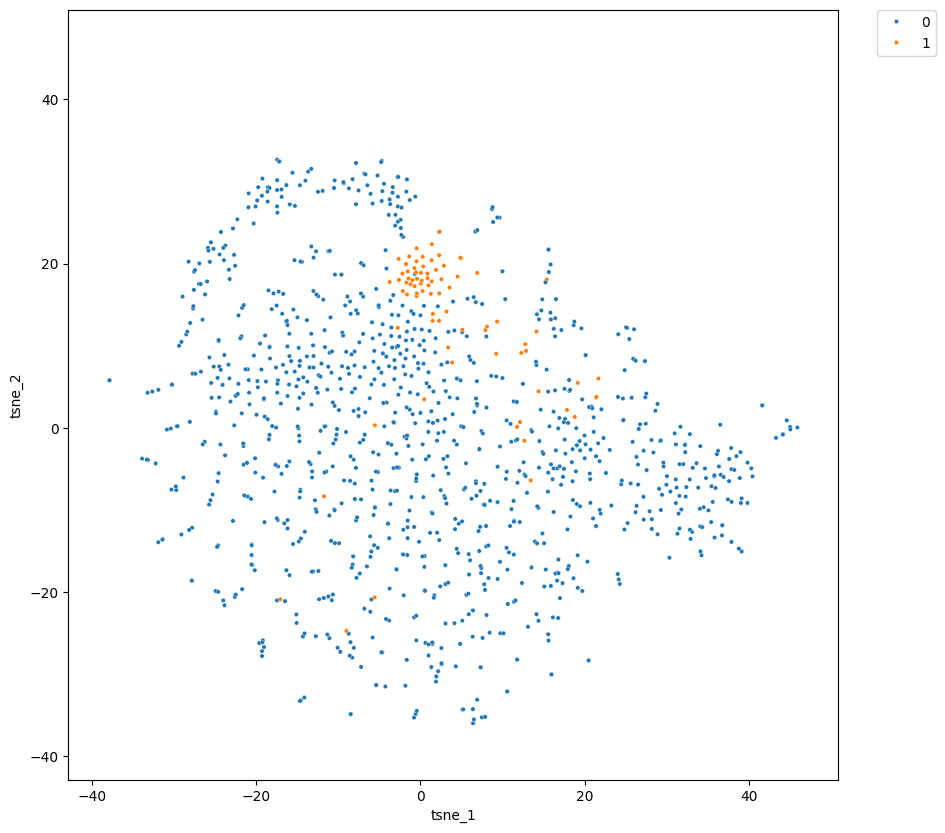

In [186]:
explore(embeddings, 'embeddings')

# Example with context nodes and input event vectors
As the history of drugs may be important to characterize patient journeys and to classify diabetes, we add 'Drug' as a context_node_label.

In [602]:
embeddings = gds.fastpath.stream(
    G,
    base_node_label="Patient",
    context_node_label="Drug",
    event_node_label="Encounter",
    event_features="emb",
    time_node_property="days",
    dimension=256,
    #num_elapsed_times=100,
    num_elapsed_times=1,
    output_time_property="output_time",
    #max_elapsed_time=365 * 10,
    max_elapsed_time=1,
    smoothing_rate=0.004,
    smoothing_window=0,
    #smoothing_window=3,
    decay_factor=1e-4,
    random_seed=43,
)



INFO:root:Job with ID 'fe2b28d9-f089-48bd-b4ab-cb3db87c132e' started
INFO:root:FastPath job completed!


Diabetes distances: 36.55922473107287
Healthy distances: 35.7292331200036
Mixed distances: 36.79281819635831
Train f1: 1.0
Test f1: 0.6738402678144428


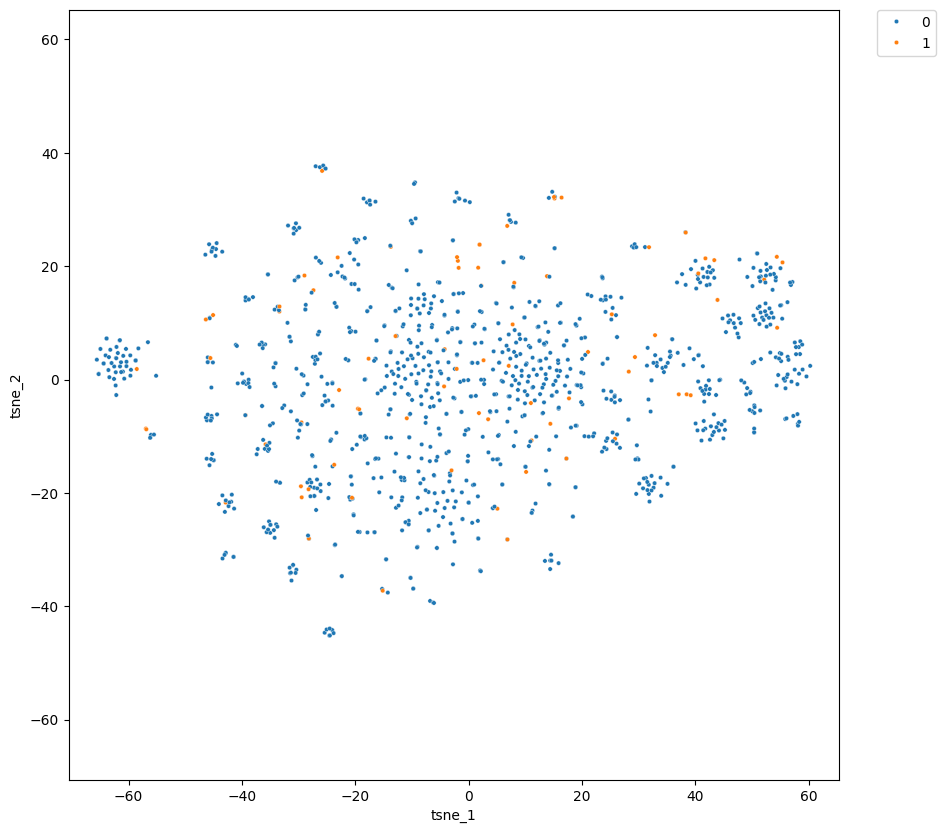

In [603]:
explore(embeddings, 'embeddings')

# Example with next and first relationship schema
We will now repeat one of the previous examples but use a different schema for the paths.
In this case it will give the same graph and embeddings, but the example is useful for illustrating the use of the next-first schema.

In [604]:
try:
    G = gds.graph.get("medical")
    G.drop()
except:
    pass

G, _ = gds.graph.project(
    "medical",
    {
        "Patient": {"properties": ["output_time", "output_time_stepwise", "has_diabetes"]},
        "Encounter": {"properties": ["days", "intClass"]},
        "Observation": {"properties": []},
        "Payer": {"properties": []},
        "Provider": {"properties": []},
        "Organization": {"properties": []},
        "Speciality": {"properties": []},
        "Allergy": {"properties": []},
        "Reaction": {"properties": []},
        "Condition": {"properties": []},
        "Drug": {"properties": []},
        "Procedure": {"properties": []},
        "CarePlan": {"properties": []},
        "Device": {"properties": []},
        "ConditionDescription": {"properties": []},
    },
    [
        "HAS_OBSERVATION",
        "NEXT",
        "FIRST",
        "HAS_PROVIDER",
        "AT_ORGANIZATION",
        "HAS_PAYER",
        "HAS_SPECIALITY",
        "BELONGS_TO",
        "INSURANCE_START",
        "INSURANCE_END",
        "HAS_ALLERGY",
        "ALLERGY_DETECTED",
        "HAS_REACTION",
        "CAUSES_REACTION",
        "HAS_CONDITION",
        "HAS_DRUG",
        "HAS_PROCEDURE",
        "HAS_CARE_PLAN",
        "DEVICE_USED",
    ],
)

In [605]:
gds.fastRP.mutate(
    G,
    embeddingDimension=256,
    mutateProperty="emb",
    iterationWeights=[1, 1],
    randomSeed=42,
    relationshipTypes=[
        "HAS_OBSERVATION",
        "HAS_PROVIDER",
        "AT_ORGANIZATION",
        "HAS_PAYER",
        "HAS_SPECIALITY",
        "BELONGS_TO",
        "INSURANCE_START",
        "INSURANCE_END",
        "HAS_ALLERGY",
        "ALLERGY_DETECTED",
        "HAS_REACTION",
        "CAUSES_REACTION",
        "HAS_CONDITION",
        "HAS_DRUG",
        "HAS_PROCEDURE",
        "HAS_CARE_PLAN",
        "DEVICE_USED",
    ]
)

nodePropertiesWritten                                                82395
mutateMillis                                                             0
nodeCount                                                            82395
preProcessingMillis                                                      0
computeMillis                                                          232
configuration            {'randomSeed': 42, 'mutateProperty': 'emb', 'j...
Name: 0, dtype: object

In [606]:
embeddings = gds.fastpath.stream(
    G,
    base_node_label="Patient",
    context_node_label="Drug",
    event_node_label="Encounter",
    event_features="emb",
    next_relationship_type="NEXT",
    first_relationship_type="FIRST",
    time_node_property="days",
    dimension=256,
    num_elapsed_times=100,
    output_time_property="output_time",
    max_elapsed_time=365 * 10,
    smoothing_rate=0.003701319681951021,
    smoothing_window=3,
    decay_factor=8.232744730741784e-05,
    random_seed=43,
)


INFO:root:Job with ID '203781c1-b594-4a81-abcc-28a232295145' started
INFO:root:FastPath job completed!


Diabetes distances: 128.25928468201968
Healthy distances: 456.9129913151665
Mixed distances: 316.99903169594506
Train f1: 1.0
Test f1: 0.9313131313131313


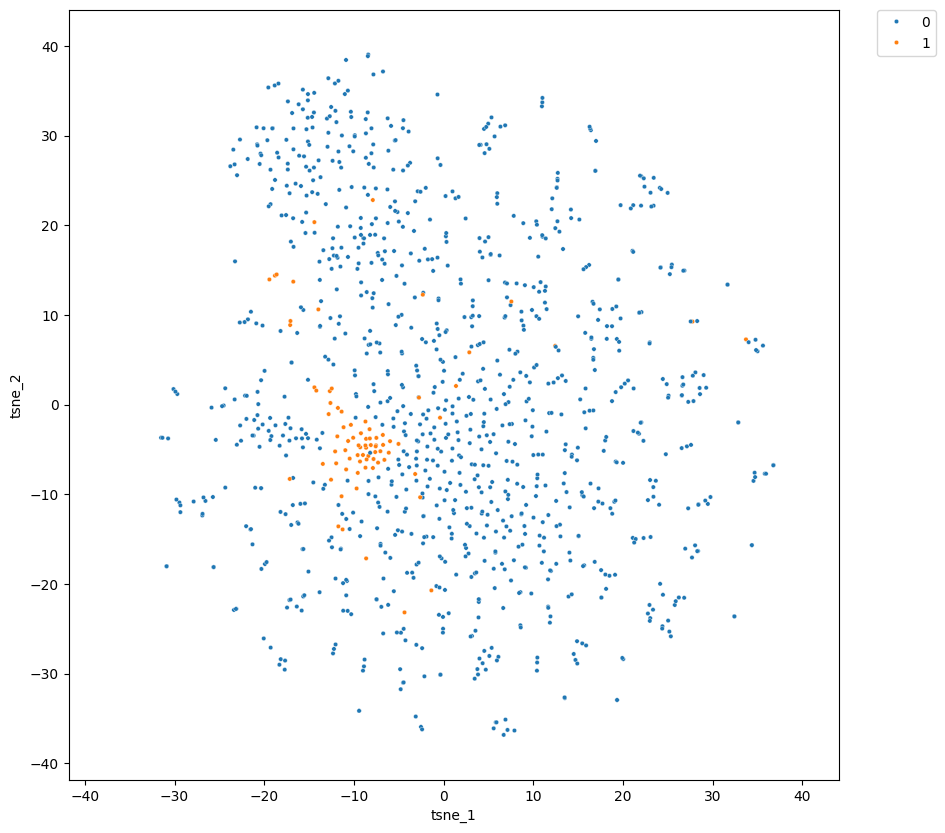

In [607]:
explore(embeddings, 'embeddings')